In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

### https://www.kaggle.com/omnamahshivai/surgical-dataset-binary-classification

In [2]:
df = pd.read_csv('data/Surgical-deepnet.csv')

In [3]:
df.head()

,bmi,Age,asa_status,baseline_cancer,baseline_charlson,baseline_cvd,baseline_dementia,baseline_diabetes,baseline_digestive,baseline_osteoart,...,complication_rsi,dow,gender,hour,month,moonphase,mort30,mortality_rsi,race,complication
0,19.31,59.2,1,1,0,0,0,0,0,0,...,-0.57,3,0,7.63,6,1,0,-0.43,1,0
1,18.73,59.1,0,0,0,0,0,0,0,0,...,0.21,0,0,12.93,0,1,0,-0.41,1,0
2,21.85,59.0,0,0,0,0,0,0,0,0,...,0.00,2,0,7.68,5,3,0,0.08,1,0
3,18.49,59.0,1,0,1,0,0,1,1,0,...,-0.65,2,1,7.58,4,3,0,-0.32,1,0
4,19.70,59.0,1,0,0,0,0,0,0,0,...,0.00,0,0,7.88,11,0,0,0.00,1,0


In [4]:
df['complication'].unique()

array([0, 1], dtype=int64)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14635 entries, 0 to 14634
Data columns (total 25 columns):
bmi                    14635 non-null float64
Age                    14635 non-null float64
asa_status             14635 non-null int64
baseline_cancer        14635 non-null int64
baseline_charlson      14635 non-null int64
baseline_cvd           14635 non-null int64
baseline_dementia      14635 non-null int64
baseline_diabetes      14635 non-null int64
baseline_digestive     14635 non-null int64
baseline_osteoart      14635 non-null int64
baseline_psych         14635 non-null int64
baseline_pulmonary     14635 non-null int64
ahrq_ccs               14635 non-null int64
ccsComplicationRate    14635 non-null float64
ccsMort30Rate          14635 non-null float64
complication_rsi       14635 non-null float64
dow                    14635 non-null int64
gender                 14635 non-null int64
hour                   14635 non-null float64
month                  14635 non-null int64

In [6]:
df.shape

(14635, 25)

In [7]:
X = df.drop('complication', axis=1)
y = df['complication']
X.shape, y.shape

((14635, 24), (14635,))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11708, 24), (2927, 24), (11708,), (2927,))

## Строим линейный классификатор на базе LogisticRegression, 
### находим наилучшее значение коэффициента регуляризации C с помощью LogisticRegressionCV

In [10]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit( X_train, y_train )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
probs = model.predict_proba(X_test)
preds = probs[:,1]

In [12]:
y_pred = model.predict( X_test )
y_pred 

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.8001366586949095

**Настройка параметра регуляризации**

In [14]:
from sklearn.linear_model import LogisticRegressionCV

In [15]:
logit_searcher = LogisticRegressionCV(Cs=np.logspace(-2, 4, 500), verbose=1, n_jobs=-1, cv=5)
logit_searcher.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.1s remaining:   19.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.3s finished


LogisticRegressionCV(Cs=array([1.00000e-02, 1.02807e-02, ..., 9.72693e+03, 1.00000e+04]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=1)

**наилучшее значение коэффициента регуляризации C**

In [16]:
logit_searcher.C_

array([0.40852858])

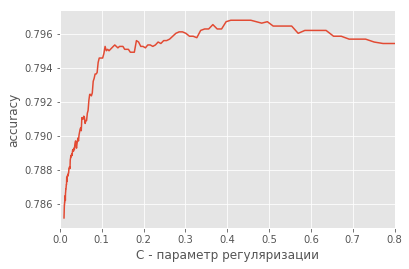

In [17]:
plt.plot(np.logspace(-2, 4, 500), np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C - параметр регуляризации')
plt.ylabel('accuracy');
plt.xlim((0,0.8));

### classification_report  для оптимальной модели

In [18]:
from sklearn.metrics import classification_report

In [19]:
print(classification_report(y_test, logit_searcher.predict(X_test)))

             precision    recall  f1-score   support

          0       0.82      0.95      0.88      2207
          1       0.68      0.35      0.47       720

avg / total       0.78      0.80      0.78      2927



###  Выводим значения коэффициентов и названия соответствующих фич для top-5 наиболее значимых коэффициентов получившейся линейной модели

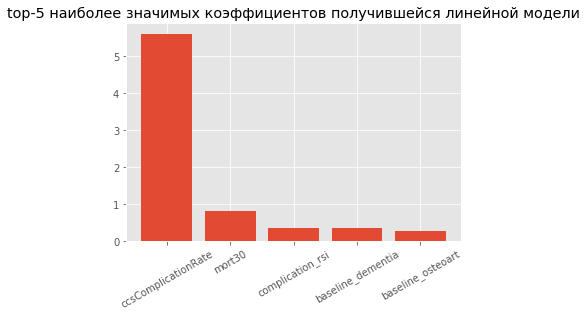

In [20]:
indices = np.argsort(np.abs(logit_searcher.coef_[0]))[::-1]
plt.figure()
plt.bar(range(5), np.abs(logit_searcher.coef_[0])[indices[:5]])
plt.xticks(range(5), X.keys()[indices[:5]], rotation=30)
plt.title("top-5 наиболее значимых коэффициентов получившейся линейной модели");

### Строим для получившегося оптимального классификатора кривые ROC и PRC

In [21]:
from sklearn.metrics import roc_curve

In [22]:
y_pred = logit_searcher.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

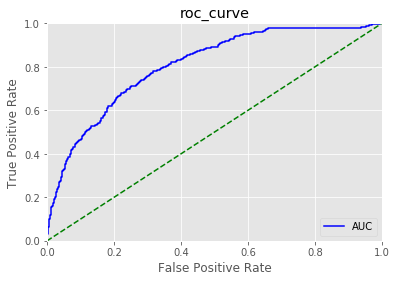

In [23]:
plt.title('roc_curve')
plt.plot(fpr, tpr, 'b', label = 'AUC')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [24]:
from sklearn.metrics import precision_recall_curve

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

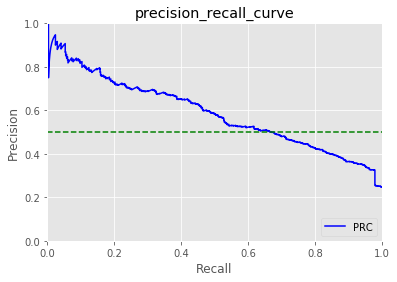

In [26]:
plt.title('precision_recall_curve')
plt.plot(recall, precision, 'b', label = 'PRC')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0.5, 0.5],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


## sklearn.preprocessing.PolynomialFeatures
### Строим классификатор используя расширенный набор признаков (с помощью sklearn.preprocessing.PolynomialFeatures).
### Строим пайплайн для PolynomialFeatures + LogisticRegression, 
### находим с помощью GridSearchCV оптимальное значение максимальной степени полинома (параметр degree для PolynomialFeatures).

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [28]:
param = {'polynomial__degree': range(1,3,1)}
logit_pipe = Pipeline(steps=[('polynomial',PolynomialFeatures()),
                           ('linear', LogisticRegressionCV(cv=5, n_jobs=-1))])

logit_pipe

Pipeline(memory=None,
     steps=[('polynomial', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linear', LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

In [29]:
logit_gridCV = GridSearchCV(logit_pipe, param,  cv=5, n_jobs=-1, verbose=False)

In [30]:
logit_gridCV.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomial', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linear', LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'polynomial__degree': range(1, 3)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

In [31]:
logit_gridCV.best_score_, logit_gridCV.best_params_

(0.7944994875298941, {'polynomial__degree': 1})

In [32]:
y_predCV = logit_gridCV.predict_proba(X_test)[:,1]

In [33]:
print(classification_report(y_test, logit_gridCV.predict(X_test)))

             precision    recall  f1-score   support

          0       0.82      0.95      0.88      2207
          1       0.68      0.34      0.46       720

avg / total       0.78      0.80      0.77      2927



### Вывод: помогли ли полиномиальные признаки, получился ли результат с ними лучше, чем без них


**Добавление полиномиальных признаков не улучшило значительно качество модели.**

**А вот по скорости обучения, очень сильно замедлило процесс.**

In [34]:
print("без полиномиальных признаков")
print(classification_report(y_test, logit_searcher.predict(X_test)))

без полиномиальных признаков
             precision    recall  f1-score   support

          0       0.82      0.95      0.88      2207
          1       0.68      0.35      0.47       720

avg / total       0.78      0.80      0.78      2927



In [35]:
print("с добавлением полиномиальных признаков")
print(classification_report(y_test, logit_gridCV.predict(X_test)))

с добавлением полиномиальных признаков
             precision    recall  f1-score   support

          0       0.82      0.95      0.88      2207
          1       0.68      0.34      0.46       720

avg / total       0.78      0.80      0.77      2927



### best_params_

In [36]:
logit_gridCV.best_score_, logit_gridCV.best_params_

(0.7944994875298941, {'polynomial__degree': 1})